In [27]:
# Libs
import matplotlib.pyplot as plt
import numpy as np

# Locals
import oggm
import oggm.cfg as cfg
import xarray as xr
import salem
import os
import pandas as pd
import geopandas as gpd
from oggm.core import flowline, inversion
from oggm import tasks, utils, workflow, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

In [28]:
utils.get_rgi_dir(version='62')  # path to the data after download

Wcan = utils.get_rgi_region_file(region='02', version='62')

gdf = gpd.read_file(Wcan)

<AxesSubplot:ylabel='Frequency'>

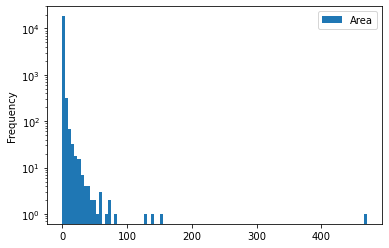

In [29]:
gdf[['Area']].plot(kind='hist', bins=100, logy=True)


<AxesSubplot:>

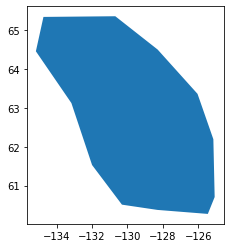

In [30]:
path = '/Users/adamhawkins/Documents/LIA_Yukon/Adam_OGGM/oggm_modified_files/YT_NWT_region.shp'
basin = gpd.read_file(path)
basin.plot()

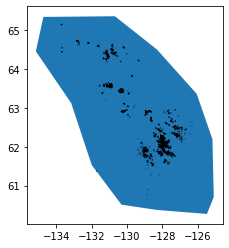

In [31]:
import shapely.geometry as shpg
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(gdf.CenLon, gdf.CenLat)]
gdf_sel = gdf.loc[in_bas]

ax = basin.plot();
gdf_sel.plot(ax=ax, edgecolor='k');

gdirs = gdf_sel

In [46]:
from oggm import cfg, workflow, tasks
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['use_multiprocessing'] = False
cfg.PARAMS['border'] = 80
cfg.PATHS['working_dir'] = utils.gettempdir('/Users/adamhawkins/OGGM/Regional_run_MRI', reset=False)

gdirs = workflow.init_glacier_directories(gdf_sel, from_prepro_level=2)
workflow.download_ref_tstars('https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/oggm_v1.4/RGIV62/CRU/centerlines/qc3/pcp2.5')

workflow.climate_tasks(gdirs)           # runs all climate related tasks
workflow.inversion_tasks(gdirs)         #runs all ice thickness inversion tasks
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
gdir = gdirs
workflow.execute_entity_task(tasks.init_present_time_glacier, gdir) ##This updates the model_flowlines file and creates a stand-alone numerical glacier ready to run.


2022-09-01 18:05:04: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-09-01 18:05:04: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-09-01 18:05:04: oggm.cfg: Multiprocessing: using all available processors (N=4)
2022-09-01 18:05:05: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2022-09-01 18:05:05: oggm.cfg: PARAMS['border'] changed from `40` to `80`.
2022-09-01 18:05:06: oggm.workflow: init_glacier_directories from prepro level 2 on 1235 glaciers.
2022-09-01 18:05:06: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1235 glaciers
2022-09-01 18:05:06: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2022-09-01 18:06:25: oggm.workflow: Applying global task climate_tasks on 1235 glaciers
2022-09-01 18:06:25: oggm.workflow: Execute entity tasks [process_climate_data] on 123

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [14]:
fls = gdirs.read_pickle('model_flowlines')

tmp = fls[1].to_geometry_dataset()


AttributeError: 'list' object has no attribute 'read_pickle'

In [15]:
from oggm.core.climate import apparent_mb_from_linear_mb
from oggm.core.massbalance import LinearMassBalance
workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad);


from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
gdir = gdirs#[0]

mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

# grad_line = np.polyfit(mb_on_z,z,2)
from scipy import stats 
slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)

params = gdir.read_pickle('linear_mb_params')
#print(params)
#max_mb Cap the mass balance to a certain value (unit: [mm w.e. yr-1], we use 2000 mm w.e.
l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'], max_mb=2000.)
l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

cfg.PARAMS['flowline_height_smooth'] = fl_smooth
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
tasks.init_present_time_glacier(gdir) ##trying to update the model flowline

NameError: name 'grad' is not defined

In [47]:
# some model settings for model spin-up
tbias = -2
years = 125
y0=1920
pf=2.5

tasks.run_constant_climate(gdirs, nyears=years, temperature_bias=tbias, y0=y0, precipitation_factor=pf)

AttributeError: 'list' object has no attribute 'get_task_status'

In [17]:
fmod = flowline.FileModel(gdir.get_filepath('model_geometry'))

AttributeError: 'list' object has no attribute 'get_filepath'

In [48]:
from tasks import process_last1000yr_data
past_climate = 3
model = ['CCSM4','MIROC','MPI','MRI']

if past_climate == 0:
    cfg.PATHS['1000yr_temp_file'] = '/Users/adamhawkins/Documents/LIA_Yukon/Adam_OGGM/tas_Amon_CCSM4_0850_2005-005.nc'
    cfg.PATHS['1000yr_prec_file'] = '/Users/adamhawkins/Documents/LIA_Yukon/Adam_OGGM/pr_Amon_CCSM4_0850_2005-004.nc'
if past_climate == 1:
    cfg.PATHS['1000yr_temp_file'] = '/Users/adamhawkins/Documents/LIA_Yukon/Adam_OGGM/tas_Amon_MIROC-ESM_0850_2005.nc'
    cfg.PATHS['1000yr_prec_file'] = '/Users/adamhawkins/Documents/LIA_Yukon/Adam_OGGM/pr_Amon_MIROC-ESM_0850_2005.nc'
if past_climate == 2:
    cfg.PATHS['1000yr_temp_file'] = '/Users/adamhawkins/Documents/LIA_Yukon/Adam_OGGM/tas_Amon_MPI-ESM-P_0850_2005.nc'
    cfg.PATHS['1000yr_prec_file'] = '/Users/adamhawkins/Documents/LIA_Yukon/Adam_OGGM/pr_Amon_MPI-ESM-P_0850_2005.nc'
if past_climate == 3:
    cfg.PATHS['1000yr_temp_file'] = '/Users/adamhawkins/Documents/LIA_Yukon/Adam_OGGM/tas_Amon_MRI-ESM2-0_0850_2014-003.nc'
    cfg.PATHS['1000yr_prec_file'] = '/Users/adamhawkins/Documents/LIA_Yukon/Adam_OGGM/pr_Amon_MRI-ESM2-0_0850_2014-002.nc'
    

In [49]:
execute_entity_task(tasks.process_last1000yr_data, gdirs)

2022-09-02 06:19:48: oggm.workflow: Execute entity tasks [process_last1000yr_data] on 1235 glaciers
2022-09-02 06:19:48: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/c

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/

/Users/adamhawkins/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [50]:
#Here, we set the tbias and pbias as the values that gave us the lowest RMSE during our individual glacier calibration runs. 

tbias = -3.81
pbias = 1.53
glena = 2.40E-24
ys = 1000 #850
ye = 2005


execute_entity_task(tasks.run_from_climate_data, gdirs, climate_filename='gcm_data', temperature_bias=tbias, 
                    precipitation_factor=pbias, glen_a = glena, ys=ys, ye=ye, #init_model_filesuffix='_no_spinup', 
                    output_filesuffix='_pr_'+str(np.round(pbias, 2))+ '_tbias_'+str(np.round(tbias, 2))+'_glena_'
                    +str(np.round(glena, 2))+'_'+model[past_climate])

utils.compile_glacier_statistics(gdirs)

ds1 = utils.compile_run_output(gdirs, input_filesuffix='_pr_'+str(np.round(pbias, 2))+
                               '_tbias_'+str(np.round(tbias, 2))+'_glena_'+str(np.round(glena, 2))
                               +'_'+model[past_climate])


2022-09-02 15:47:25: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1235 glaciers
2022-09-02 15:47:25: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2022-09-02 15:47:25: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:47:37: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:47:48: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:47:56: ogg

2022-09-02 15:54:09: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:54:14: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:54:19: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:54:24: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:54:30: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 15:57:49: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:57:53: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:57:58: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:58:03: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 15:58:07: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:02:10: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:02:20: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:02:25: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:02:30: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:02:37: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:05:13: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:05:23: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:05:46: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:05:52: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:06:03: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:10:45: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:10:50: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:10:56: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:11:04: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:11:09: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:13:44: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:13:48: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:13:53: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:14:00: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:14:04: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:16:46: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:16:50: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:16:55: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:17:00: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:17:05: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:20:58: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:21:03: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:21:08: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:21:12: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:21:17: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:23:46: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:23:50: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:23:54: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:23:59: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:24:04: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:26:47: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:26:52: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:26:56: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:27:01: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:27:05: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:29:41: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:29:45: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:29:50: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:29:54: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:29:58: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:32:45: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:32:50: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:32:56: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:33:01: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:33:06: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:35:50: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:35:57: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:36:02: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:36:06: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:36:10: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:40:01: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:40:07: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:40:11: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:40:16: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:40:26: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:44:41: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:44:45: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:44:49: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:44:54: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:44:59: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:48:05: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:48:10: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:48:15: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:48:19: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:48:28: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:51:38: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:51:43: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:51:47: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:51:52: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:51:57: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:55:06: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:55:11: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:55:16: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:55:21: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:55:26: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 16:58:35: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:58:40: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:58:45: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:58:50: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 16:58:55: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:02:20: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:02:25: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:02:30: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:02:34: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:02:39: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:05:31: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:05:41: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:05:46: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:05:52: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:06:00: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:09:26: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:09:31: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:09:36: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:09:40: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:09:44: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:13:44: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:13:49: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:13:53: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:14:07: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:14:27: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:18:07: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:18:12: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:18:17: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:18:40: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:18:45: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:22:31: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:22:35: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:22:45: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:22:50: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:22:55: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:25:31: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:25:36: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:25:41: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:25:46: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:25:51: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:28:56: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:29:01: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:29:06: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:29:11: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:29:21: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:32:43: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:32:48: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:32:54: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:33:03: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:33:08: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:35:49: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:35:55: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:36:00: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:36:10: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:36:15: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:39:20: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:39:29: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:39:37: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:39:46: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:39:50: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:42:45: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:42:50: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:42:55: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:42:59: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:43:09: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:45:39: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:45:43: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:45:48: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:45:57: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:46:02: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:50:00: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:50:05: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:50:09: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:50:14: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:50:19: oggm.core.flowline: You are attempting to run_with_clim

2022-09-02 17:52:50: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:52:54: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:52:59: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:53:03: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-09-02 17:53:07: oggm.core.flowline: You are attempting to run_with_clim

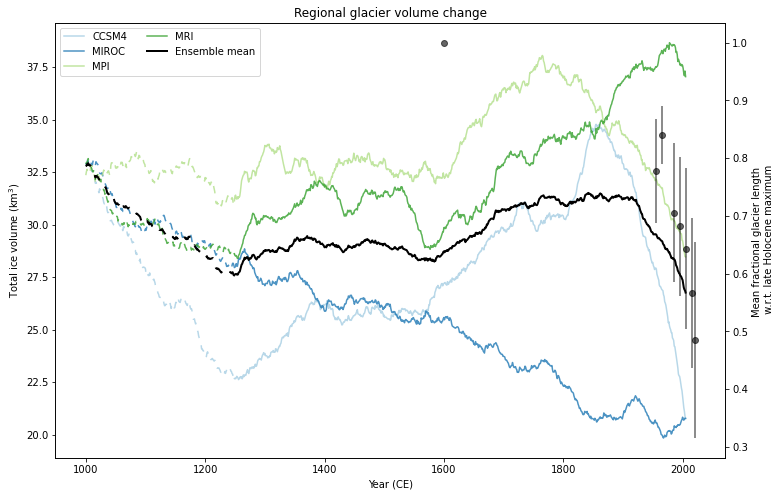

In [35]:
#Plotting results

import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.style as style
style.use('tableau-colorblind10')

CCSM_results = '/Users/adamhawkins/OGGM/Regional_run/run_output_pr_1.27_tbias_-3.01_glena_0.0_CCSM4.nc'
MIROC_results = '/Users/adamhawkins/OGGM/Regional_run/run_output_pr_1.68_tbias_-3.17_glena_0.0_MIROC.nc'
MPI_results = '/Users/adamhawkins/OGGM/Regional_run_MPI/run_output_pr_1.5_tbias_-3.17_glena_0.0_MPI.nc'
MRI_results = '/Users/adamhawkins/OGGM/Regional_run_MRI/run_output_pr_1.53_tbias_-3.81_glena_0.0_MRI.nc'

fpath = [CCSM_results, MIROC_results, MPI_results, MRI_results]
fig, ax1 = plt.subplots(figsize = (12,8))

for data in fpath:
    
    da = xr.open_dataset(data)
    vol = da.volume.sum(dim='rgi_id')
    vol_spin = vol[:250]
    vol_rest = vol[249:]
    if data == CCSM_results:
        label = 'CCSM4'
        color = '#a6cee3'
    if data == MIROC_results:
        label = 'MIROC'
        color = '#1f78b4'
    if data == MPI_results:
        label = 'MPI'
        color = '#b2df8a'
    if data == MRI_results:
        label = 'MRI'
        color = '#33a02c'
        
        #Colors from https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=4

    max_y = max(vol)  # Find the maximum y value
    max_x = vol.time[vol.argmax()]  # Find the x value corresponding to the maximum y value
    
    #set random color here?
    #data=df[df['dates'] < 2004]  data=da[da['time']<1250]
    
  #  ax1.plot(da.time, (vol*1e-9), linestyle = 'dashed', label=label, alpha = 0.8)
    ax1.plot(da.time[:250], (vol_spin*1e-9), linestyle = (0, (5, 5)), color = color, alpha = 0.8)
    ax1.plot(da.time[249:], (vol_rest*1e-9), linestyle = 'solid', label = label, color = color, alpha = 0.8)
    ax1.set_title('Regional glacier volume change')
    ax1.set_xlabel('Year (CE)')
    ax1.set_ylabel('Total ice volume (km$^3$)')
    #plt.legend(loc='upper left', ncol=2)
da = xr.open_dataset(CCSM_results)
CCSM_vol = da.volume.sum(dim='rgi_id')

da = xr.open_dataset(MIROC_results)
MIROC_vol = da.volume.sum(dim='rgi_id')

da = xr.open_dataset(MPI_results)
MPI_vol = da.volume.sum(dim='rgi_id')

da = xr.open_dataset(MRI_results)
MRI_vol = da.volume.sum(dim='rgi_id')

ens_mean = np.mean(np.array([CCSM_vol, MIROC_vol, MPI_vol, MRI_vol]), axis=0)
ax1.plot(da.time[:250], (ens_mean[:250])*1e-9, linewidth = 2, color = 'k', linestyle = (0, (5, 5)))
ax1.plot(da.time[249:], (ens_mean[249:])*1e-9, linewidth = 2, color = 'k', linestyle = '-', label = 'Ensemble mean')

ax1.legend(loc='upper left', ncol=2)

decades = [1600, 1955, 1965, 1985, 1995, 2005, 2015, 2020]
avg_percent = [1,0.778243758,0.84,0.705489565,0.681666667,0.643333333,0.566,0.485]
yerr = [0.00,0.09,0.05,0.12,0.12,0.14,0.13,0.17]

ax2=ax1.twinx()

ax2.errorbar(decades, avg_percent,yerr, fmt='o', color = 'k',label = 'mean fractional glacier length', alpha=0.6)
ax2.set_ylabel('Mean fractional glacier length \n w.r.t. late Holocene maximum')

ax1.legend(loc='upper left', ncol=2)
plt.savefig('/Users/adamhawkins/Documents/LIA_Yukon/Figures/Regional_AllRuns.jpg', dpi=600, bbox_inches='tight')
# plt.show()

In [13]:
#Following sections project future glacier change in the Mackenzie and Selwyn Mountains tuntil 2100 CE. 
#Vast majorty of the code used is modified from tutorials on OGGM.org

# Libs
import matplotlib.pyplot as plt
import numpy as np

# Locals
import oggm
import oggm.cfg as cfg
import xarray as xr
import salem
import os
import pandas as pd
import geopandas as gpd
from oggm.core import flowline, inversion
from oggm import tasks, utils, workflow, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

cfg.initialize()

from oggm import cfg, workflow, tasks, utils
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['border'] = 80
cfg.PATHS['working_dir'] = utils.gettempdir('/Users/adamhawkins/OGGM/Regional_future', reset=True)

2022-05-01 19:58:02: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-05-01 19:58:02: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-05-01 19:58:02: oggm.cfg: Multiprocessing: using all available processors (N=4)
2022-05-01 19:58:02: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-05-01 19:58:02: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-05-01 19:58:02: oggm.cfg: Multiprocessing: using all available processors (N=4)
2022-05-01 19:58:02: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2022-05-01 19:58:02: oggm.cfg: Multiprocessing switched ON after user settings.
2022-05-01 19:58:02: oggm.cfg: PARAMS['border'] changed from `40` to `80`.


In [14]:
utils.get_rgi_dir(version='62')  # path to the data after download

Wcan = utils.get_rgi_region_file(region='02', version='62')

gdf = gpd.read_file(Wcan)

<AxesSubplot:>

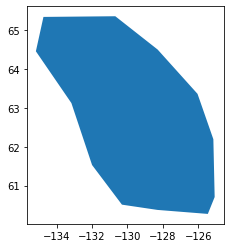

In [15]:
path = '/Users/adamhawkins/Documents/LIA_Yukon/Adam_OGGM/oggm_modified_files/YT_NWT_region.shp'
basin = gpd.read_file(path)
basin.plot()

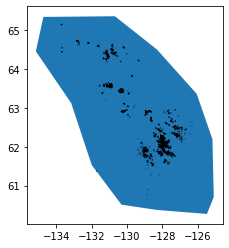

In [16]:
import shapely.geometry as shpg
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(gdf.CenLon, gdf.CenLat)]
gdf_sel = gdf.loc[in_bas]

ax = basin.plot();
gdf_sel.plot(ax=ax, edgecolor='k');

gdirs = gdf_sel

In [17]:
fpath = '/Users/adamhawkins/Documents/LIA_Yukon/'

rgi_list = gdf_sel.RGIId

In [23]:
cfg.PARAMS['use_multiprocessing'] = False
gdirs = workflow.init_glacier_directories(gdf_sel, from_prepro_level=5, prepro_border=80)
# workflow.download_ref_tstars('https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/oggm_v1.4/RGIV62/CRU/centerlines/qc3/pcp2.5')

2022-05-02 07:08:31: oggm.workflow: init_glacier_directories from prepro level 5 on 1235 glaciers.
2022-05-02 07:08:31: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1235 glaciers
2022-05-02 07:08:31: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
100% of  45.2 MiB |######################| Elapsed Time: 0:00:30 Time:  0:00:30
100% of  52.0 MiB |######################| Elapsed Time: 0:00:33 Time:  0:00:33


In [24]:
workflow.execute_entity_task(tasks.run_from_climate_data, gdirs, 
                             output_filesuffix='_my_spinup',  # to use the files as input later on
                            );
ds = utils.compile_run_output(gdirs, input_filesuffix='_my_spinup')
#ds.volume.plot(hue='rgi_id');

2022-05-02 07:12:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1235 glaciers
2022-05-02 07:12:56: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2022-05-02 07:17:50: oggm.utils: Applying global task compile_run_output on 1235 glaciers
2022-05-02 07:17:50: oggm.utils: Applying compile_run_output on 1235 gdirs.


AttributeError: 'NoneType' object has no attribute 'volume'

In [26]:
from oggm.shop import gcm_climate

bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                                 filesuffix='_CCSM4_{}'.format(rcp),  # recognize the climate file for later
                                 fpath_temp=ft,  # temperature projections
                                 fpath_precip=fp,  # precip projections
                                 );

2022-05-02 07:22:05: oggm.workflow: Execute entity tasks [process_cmip_data] on 1235 glaciers
2022-05-02 07:22:05: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2022-05-02 07:56:42: oggm.workflow: Execute entity tasks [process_cmip_data] on 1235 glaciers
2022-05-02 07:56:42: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2022-05-02 08:32:06: oggm.workflow: Execute entity tasks [process_cmip_data] on 1235 glaciers
2022-05-02 08:32:06: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2022-05-02 09:08:07: oggm.workflow: Execute entity tasks [process_cmip_data] on 1235 glaciers
2022-05-02 09:08:07: oggm.workflow: WARNING: you are trying to run an

In [27]:
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    workflow.execute_entity_task(tasks.run_from_climate_data, gdirs, ys=2020, 
                                 climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                 climate_input_filesuffix=rid,  # use the chosen scenario
                                 init_model_filesuffix='_historical',  # this is important! Start from 2020 glacier
                                 output_filesuffix=rid,  # recognize the run for later
                                );

2022-05-02 10:00:52: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1235 glaciers
2022-05-02 10:00:52: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2022-05-02 10:13:35: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1235 glaciers
2022-05-02 10:13:35: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2022-05-02 10:25:42: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1235 glaciers
2022-05-02 10:25:42: oggm.workflow: WARNING: you are trying to run an entity task on 1235 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2022-05-02 10:37:46: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1235 glaciers
2022-05-02 10:37:46: oggm.workflow: WARNING: you are 

2022-05-02 11:11:56: oggm.utils: Applying global task compile_run_output on 1235 glaciers
2022-05-02 11:11:56: oggm.utils: Applying compile_run_output on 1235 gdirs.
2022-05-02 11:12:11: oggm.utils: Applying global task compile_run_output on 1235 glaciers
2022-05-02 11:12:11: oggm.utils: Applying compile_run_output on 1235 gdirs.
2022-05-02 11:12:26: oggm.utils: Applying global task compile_run_output on 1235 glaciers
2022-05-02 11:12:26: oggm.utils: Applying compile_run_output on 1235 gdirs.
2022-05-02 11:12:42: oggm.utils: Applying global task compile_run_output on 1235 glaciers
2022-05-02 11:12:42: oggm.utils: Applying compile_run_output on 1235 gdirs.


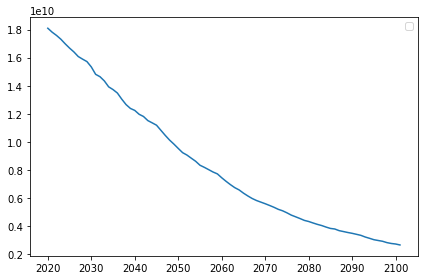

In [30]:
##Plot simulation results, let's start with cumulative volume loss projections
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    ds = utils.compile_run_output(gdirs, input_filesuffix=rid)


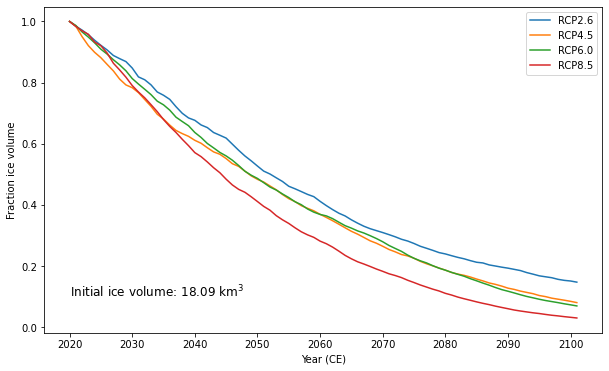

In [23]:
import xarray as xr
import matplotlib.pyplot as plt

path26 = '/Users/adamhawkins/OGGM/Regional_future/run_output_CCSM4_rcp26.nc'
path45 = '/Users/adamhawkins/OGGM/Regional_future/run_output_CCSM4_rcp45.nc'
path60 = '/Users/adamhawkins/OGGM/Regional_future/run_output_CCSM4_rcp60.nc'
path85 = '/Users/adamhawkins/OGGM/Regional_future/run_output_CCSM4_rcp85.nc'
ds1 = xr.open_dataset(path26)
ds2 = xr.open_dataset(path45)
ds3 = xr.open_dataset(path60)
ds4 = xr.open_dataset(path85)

vol1= (ds1.volume.sum(dim='rgi_id'))*1e-9
frac_vol1=vol1/max(vol1)
vol2= (ds2.volume.sum(dim='rgi_id'))*1e-9
frac_vol2=vol2/max(vol2)
vol3= (ds3.volume.sum(dim='rgi_id'))*1e-9
frac_vol3=vol3/max(vol3)
vol4= (ds4.volume.sum(dim='rgi_id'))*1e-9
frac_vol4=vol4/max(vol4)

#make plot of fraction of max (i.e. 2019 CE volume). Find atvlue at 2019 and make rest of time
#series normalized to that
# fig = plt.plot(figsize = (12,8))
plt.figure(figsize=(10,6))
plt.plot(ds1.time, frac_vol1, label ='RCP2.6')
plt.plot(ds1.time, frac_vol2, label ='RCP4.5')
plt.plot(ds1.time, frac_vol3, label ='RCP6.0')
plt.plot(ds1.time, frac_vol4, label ='RCP8.5')
plt.text(2020, 0.1, 'Initial ice volume: 18.09 km$^3$', size = 'large')
plt.xlabel('Year (CE)')
plt.ylabel('Fraction ice volume') # (km$^3$)')

plt.legend()

plt.savefig('/Users/adamhawkins/Documents/LIA_Yukon/Figures/Future_Icevol.jpg', dpi=600)
plt.show()

# min_y = min(vol4)  # Find the maximum y value
# min_x = ds4.time[vol4.argmin()]  # Find the x value corresponding to the maximum y value
# print (min_x, min_y)